In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os, random
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
print(test_df)

       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
27995       0       0       0       0       0       0       0       0       0   
27996       0       0       0       0       0       0       0       0       0   
27997       0       0       0       0       0       0       0       0       0   
27998       0       0       0       0       0       0       0       0       0   
27999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel77

In [4]:
train_dat = train_df.values
test_dat = test_df.values

index = list(range(len(train_dat[:,1:])))
random.shuffle(index)
val_ratio = 0.2
train_index = index[:np.int(len(train_dat)*(1-val_ratio))]
val_index = index[np.int(len(train_dat)*(1-val_ratio)):]

X_train = train_dat[train_index,1:]
X_val = train_dat[val_index,1:]
X_test = test_dat

Y_train = train_dat[train_index,0]
Y_val = train_dat[val_index,0]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)

(33600, 784)
(8400, 784)
(28000, 784)
(33600,)
(8400,)


In [5]:
X_train_vec = np.zeros((len(X_train),28,28,1), dtype=np.float32)
X_val_vec = np.zeros((len(X_val),28,28,1), dtype=np.float32)
X_test_vec = np.zeros((len(X_test),28,28,1), dtype=np.float32)

for idx in range(len(X_train)):
    X_train_vec[idx,:,:,0] = X_train[idx,:].reshape(28,28)
for idx in range(len(X_val)):
    X_val_vec[idx,:,:,0] = X_val[idx,:].reshape(28,28)
for idx in range(len(X_test)):
    X_test_vec[idx,:,:,0] = X_test[idx,:].reshape(28,28)

print(X_train_vec.shape)
print(X_val_vec.shape)
print(X_test_vec.shape)

(33600, 28, 28, 1)
(8400, 28, 28, 1)
(28000, 28, 28, 1)


In [6]:
encoder = {
    0: [0,0,0,0,0,0,0,0,0,1],
    1: [0,0,0,0,0,0,0,0,1,0],
    2: [0,0,0,0,0,0,0,1,0,0],
    3: [0,0,0,0,0,0,1,0,0,0],
    4: [0,0,0,0,0,1,0,0,0,0],
    5: [0,0,0,0,1,0,0,0,0,0],
    6: [0,0,0,1,0,0,0,0,0,0],
    7: [0,0,1,0,0,0,0,0,0,0],
    8: [0,1,0,0,0,0,0,0,0,0],
    9: [1,0,0,0,0,0,0,0,0,0],
}
def onehotcode(data):
    return encoder[data]

Y_train_vec = np.zeros((len(Y_train),10), dtype=np.float32)
Y_val_vec = np.zeros((len(Y_val),10), dtype=np.float32)

for idx, data in enumerate(Y_train):
    Y_train_vec[idx,:] = onehotcode(data)
for idx, data in enumerate(Y_val):
    Y_val_vec[idx,:] = onehotcode(data)  
    
print(Y_train_vec.shape)
print(Y_val_vec.shape)

(33600, 10)
(8400, 10)


In [7]:
import matplotlib.pyplot as plt

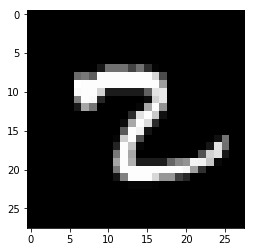

In [8]:
img = np.squeeze(X_train_vec[0,:])
plt.imshow(img,cmap='gray')
plt.show()

In [9]:
import sys
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import numpy as np

Using TensorFlow backend.


In [10]:
input_shape = X_train_vec.shape[1:]
print(input_shape)

(28, 28, 1)


In [11]:
from keras import Input
from keras.models import Model, load_model
from keras.layers import BatchNormalization, Conv2D, Activation, Add
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D

layer = 18

if layer == 18:
    repetitions = [2,2,2,2]
    skip_layer = False
elif layer == 34:
    repetitions = [3,4,6,3]
    skip_layer = False
elif layer == 50:
    repetitions = [3,4,6,3]
    skip_layer = True
elif layer == 101:
    repetitions = [3,4,23,3]
    skip_layer = True
elif layer == 152:
    repetitions = [3,8,36,3]
    skip_layer = True

input_tensor = Input(shape=(28, 28, 1), dtype='float32', name='input')

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(repetitions[0]):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            if skip_layer:
                x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
                shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
                x = BatchNormalization()(x)
                shortcut = BatchNormalization()(shortcut)
 
                x = Add()([x, shortcut])
                x = Activation('relu')(x)
            
                shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            if skip_layer:
                x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)            
 
                x = Add()([x, shortcut])   
                x = Activation('relu')(x)  
 
                shortcut = x        
    
    return x
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(repetitions[1]):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            if skip_layer:
                x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
                shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
                x = BatchNormalization()(x)
                shortcut = BatchNormalization()(shortcut)            
 
                x = Add()([x, shortcut])    
                x = Activation('relu')(x)    
 
                shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            if skip_layer:
                x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)            
 
                x = Add()([x, shortcut])     
                x = Activation('relu')(x)
 
                shortcut = x      
            
    return x
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(repetitions[2]):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            if skip_layer:
                x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
                shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
                x = BatchNormalization()(x)
                shortcut = BatchNormalization()(shortcut)
 
                x = Add()([x, shortcut]) 
                x = Activation('relu')(x)
 
                shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            if skip_layer:
                x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)            
 
                x = Add()([x, shortcut])    
                x = Activation('relu')(x)
 
                shortcut = x      
 
    return x
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(repetitions[3]):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            if skip_layer:
                x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
                shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
                x = BatchNormalization()(x)
                shortcut = BatchNormalization()(shortcut)            
 
                x = Add()([x, shortcut])  
                x = Activation('relu')(x)      
 
                shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            if skip_layer:
                x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)           
            
                x = Add()([x, shortcut]) 
                x = Activation('relu')(x)       
 
                shortcut = x                  
 
    return x
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(10, activation='softmax')(x)
 
model = Model(input_tensor, output_tensor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
__________

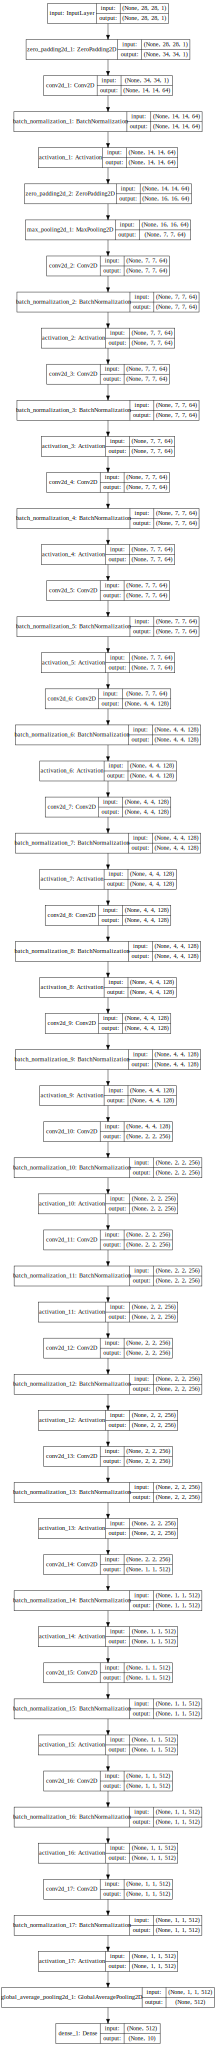

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
batch_size = 128
epochs = 20
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
hist = model.fit(X_train_vec, Y_train_vec,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1, 
                 validation_data=(X_val_vec, Y_val_vec))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 533s 16ms/step - loss: 0.6996 - acc: 0.7676 - val_loss: 0.2854 - val_acc: 0.9095
Epoch 2/20
33600/33600 [==============================] - 527s 16ms/step - loss: 0.1585 - acc: 0.9496 - val_loss: 0.1768 - val_acc: 0.9452
Epoch 3/20
33600/33600 [==============================] - 537s 16ms/step - loss: 0.0748 - acc: 0.9768 - val_loss: 0.1620 - val_acc: 0.9529
Epoch 4/20
33600/33600 [==============================] - 535s 16ms/step - loss: 0.0410 - acc: 0.9871 - val_loss: 0.1587 - val_acc: 0.9532
Epoch 5/20
33600/33600 [==============================] - 541s 16ms/step - loss: 0.0301 - acc: 0.9907 - val_loss: 0.1521 - val_acc: 0.9612
Epoch 6/20
33600/33600 [==============================] - 534s 16ms/step - loss: 0.0256 - acc: 0.9917 - val_loss: 0.1556 - val_acc: 0.9596
Epoch 7/20
33600/33600 [==============================] - 521s 16ms/step - loss: 0.0277 - acc: 0.9906 - val_loss: 0.1

In [14]:
def drawLoss(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='lower left')

    acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()
    
def saveLoss(hist):
    acc = np.array(hist.history['acc'])
    val_acc = np.array(hist.history['val_acc'])
    loss = np.array(hist.history['loss'])
    val_loss = np.array(hist.history['val_loss'])

    np.savetxt("acc.txt", acc, delimiter=",")
    np.savetxt("val_acc.txt", val_acc, delimiter=",")
    np.savetxt("loss.txt", loss, delimiter=",")
    np.savetxt("val_loss.txt", val_loss, delimiter=",")

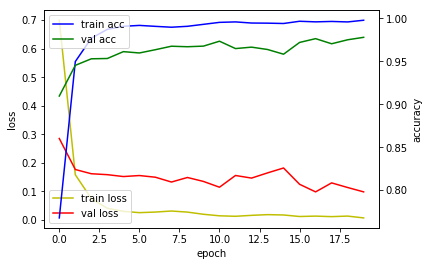

In [15]:
drawLoss(hist)
saveLoss(hist)

In [16]:
score = model.evaluate(X_val_vec, Y_val_vec, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.09840279405624772
Validation accuracy: 0.9778571428571429


In [17]:
def save(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file : 
        json_file.write(model_json)
    model.save_weights("model.h5")
    print("Saved model to disk")
    
save(model)

Saved model to disk


In [18]:
from keras.models import model_from_json 

def load(model):
    json_file = open(model+".json", "r")
    loaded_model_json = json_file.read() 
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model+".h5")
    print("Loaded model from disk")
    return loaded_model

In [19]:
#load('model')

#batch_size = 16
#epochs = 50
#adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#hist = model.fit(X_train_vec, Y_train_vec,
#                 batch_size=batch_size,
#                 epochs=epochs,
#                 verbose=1, 
#                 validation_data=(X_val_vec, Y_val_vec))

In [20]:
pred = model.predict(X_test_vec)

In [21]:
def decode(data):
    return (9-list(data).index(max(data)))

result = []
for data in pred:
    result.append(decode(data))

In [22]:
print(result)

[2, 0, 9, 2, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 5, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 5, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 9, 2, 0, 7, 3, 0, 5, 0, 9, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8, 6, 3, 8, 7, 8, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 2, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 2, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 3, 2, 1, 6, 3, 4, 2, 3, 1, 2, 2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 3, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 6, 9, 7, 1, 3, 8, 4, 5, 1, 4, 5, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0, 6, 3, 9, 9, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 1, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 0, 3, 7, 1, 4, 5, 8, 5, 9, 0, 0, 3, 9, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 5, 3, 6, 3, 1, 

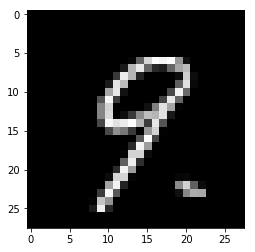

In [23]:
timg = np.squeeze(X_test_vec[2,:])
plt.imshow(timg,cmap='gray')
plt.show()

In [24]:
fname = './submission.csv'

with open(fname,'w') as f:
    f.write('ImageId,Label\n')
    for idx, res in enumerate(result):
        f.write(str(idx+1)+','+str(res)+'\n')